In [1]:
# import ambulance_game as abg
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from ambulance_game.simulation import (
    simulate_model,
    get_average_simulated_state_probabilities,
)

from ambulance_game.markov import (
    visualise_markov_chain,
    is_accepting_state,
    build_states,
    get_transition_matrix,
    get_steady_state_algebraically,
    get_markov_state_probabilities,
)

# Simulation

In [3]:
def extract_total_individuals_and_the_ones_within_target_for_both_classes(individuals, target):
    class_2_inds, class_2_inds_within_target = 0, 0
    class_1_inds, class_1_inds_within_target = 0, 0
    for individual in individuals:
        ind_class = len(individual.data_records) - 1
        rec = individual.data_records[-1]
        if rec.node == 2 and ind_class == 0:
            class_1_inds += 1
            if rec.waiting_time < target: #+ rec.service_time
                class_1_inds_within_target += 1
        elif rec.node == 2 and ind_class == 1:
            class_2_inds += 1
            if rec.waiting_time < target: #+ rec.service_time
                class_2_inds_within_target += 1

    return class_2_inds, class_2_inds_within_target, class_1_inds, class_1_inds_within_target

In [4]:
def get_mean_proportion_of_individuals_within_target_for_multiple_runs(
    lambda_2,
    lambda_1,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    buffer_capacity,
    seed_num,
    num_of_trials,
    runtime,
    target,
):
    class_2_proportions = []
    class_1_proportions = []
    combined_proportions = []

    if seed_num == None:
        seed_num = random.random()

    for trial in range(num_of_trials):
        individuals = simulate_model(
            lambda_2=lambda_2, 
            lambda_1=lambda_1, 
            mu=mu,
            num_of_servers=num_of_servers, 
            threshold=threshold,
            system_capacity=system_capacity,
            buffer_capacity=buffer_capacity,
            seed_num=seed_num + trial, 
            runtime=runtime
        ).get_all_individuals()
        (
            class_2_inds,
            class_2_inds_within_target,
            class_1_inds,
            class_1_inds_within_target,
        ) = extract_total_individuals_and_the_ones_within_target_for_both_classes(individuals, target)

        class_2_proportions.append(
            (class_2_inds_within_target / class_2_inds) if class_2_inds != 0 else 1
        )
        class_1_proportions.append(
            (class_1_inds_within_target / class_1_inds) if class_1_inds != 0 else 1
        )
        combined_proportions.append(
            (class_2_inds_within_target + class_1_inds_within_target)
            / (class_2_inds + class_1_inds)
            if (class_2_inds + class_1_inds) != 0
            else 1
        )

    return combined_proportions, class_1_proportions, class_2_proportions

# Markov Chains

## Utils function

In [5]:
def get_probability_of_accepting(
    all_states,
    pi,
    threshold, 
    system_capacity, 
    buffer_capacity,
):
    prob_accept = [
        np.sum(
            [
                pi[state]
                for state in all_states
                if is_accepting_state(
                    state=state,
                    class_type=class_type,
                    threshold=threshold,
                    system_capacity=system_capacity,
                    buffer_capacity=buffer_capacity,
                )
            ]
        )
        for class_type in range(2)
    ]
    return prob_accept


def get_proportion_of_individuals_not_lost(
    all_states,
    pi,
    lambda_1,
    lambda_2,
    threshold,
    system_capacity,
    buffer_capacity,
):
    prob_accept = get_probability_of_accepting(
        all_states,
        pi,
        threshold,
        system_capacity,
        buffer_capacity,
    )
    class_rates = [
        prob_accept[class_type]
        / ((lambda_2 * prob_accept[1]) + (lambda_1 * prob_accept[0]))
        for class_type in range(2)
    ]
    class_rates[0] *= lambda_1
    class_rates[1] *= lambda_2

    return class_rates

In [6]:
lambda_2 = 2
lambda_1 = 2
mu = 2

num_of_servers = 2
threshold = 5
system_capacity = 20
buffer_capacity = 10

target = 4

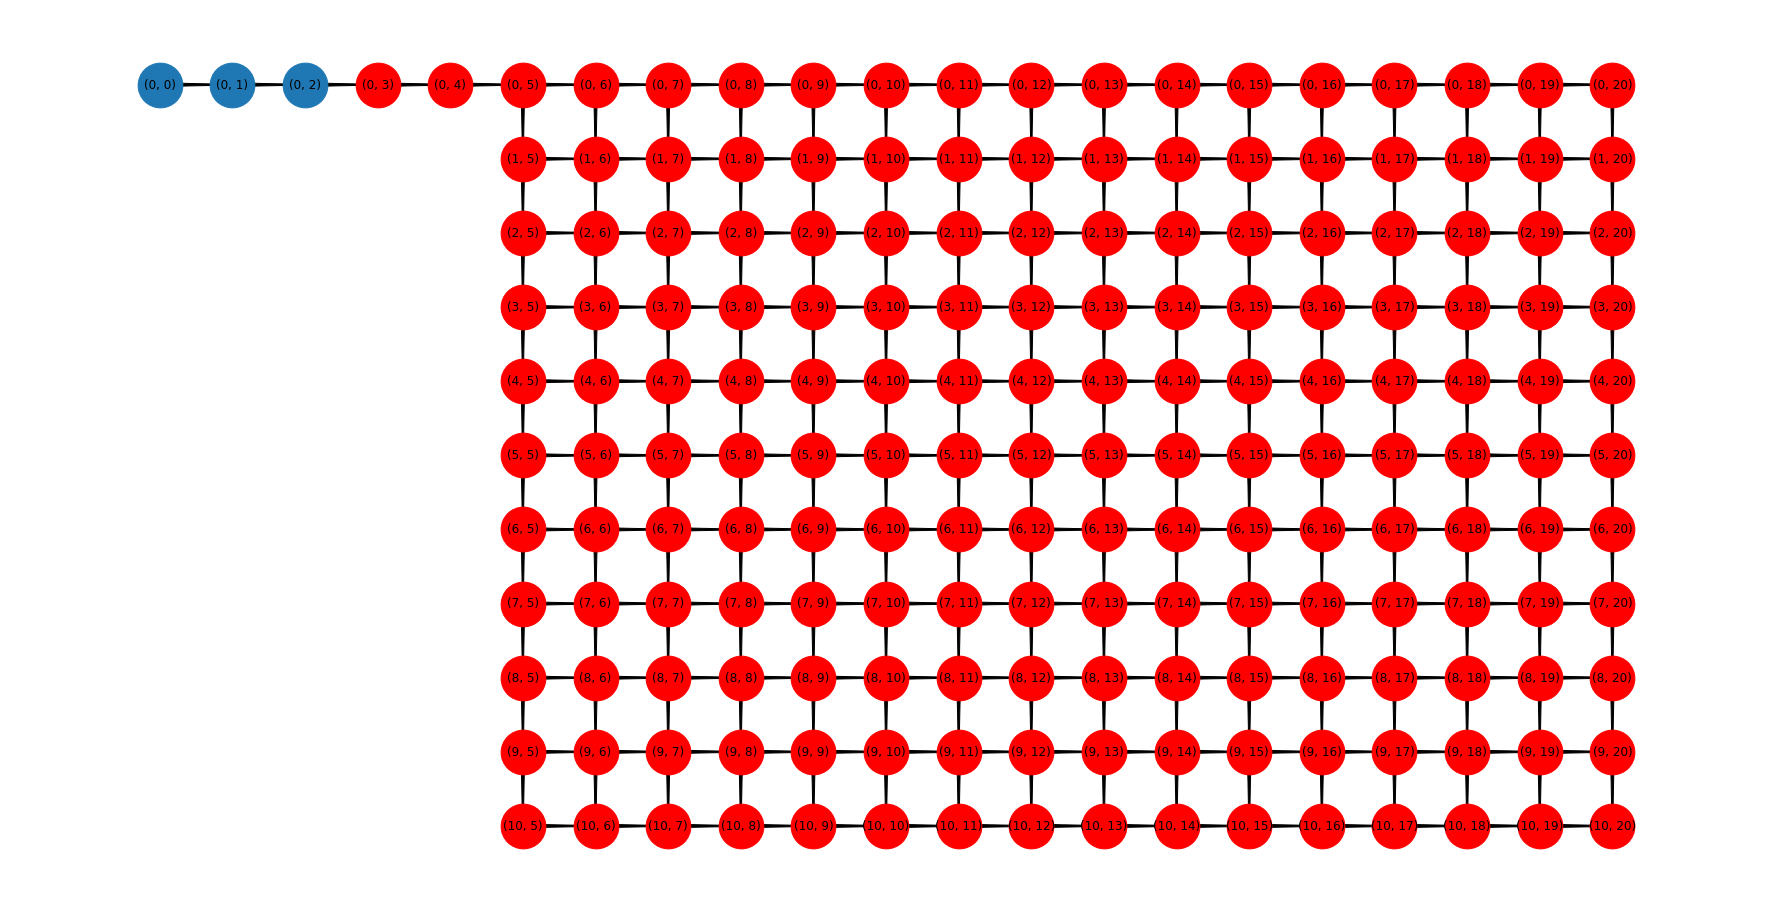

In [7]:
visualise_markov_chain(
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
)

## Theory:

**Sum of exponentially distributed random varable results in Erlang distributed R.V.**

$X_i \sim Exp(\lambda) \qquad \Rightarrow \qquad X_1 + X_2 + \dots + X_k \sim Erlang(k, \lambda)$

**Applied to Markov chain**

$S_7 = X_{0,7} + X_{0,6} + X_{0,5} + X_{0,4} + X_{0,3} + X_{0,2}$

$X_{0,2}$ has a different exponential parameter than the other ones and cannot be combined to form Erlang distribution

By just considering the waiting time (excluding service time):

$S_{0,7} = X_{0,7} + X_{0,6} + X_{0,5} + X_{0,4} + X_{0,3} \sim Erlang(k, \lambda)$

$P(S_{0,7} < 4) = 1 - \sum_{i=0}^{k-1} \frac{e^{-4\lambda} (4 \lambda)^i}{i!}$

## Modifications to include service time

TBA

In [8]:
# Function for just waiting time
def get_probability_of_waiting_time_in_system_less_than_target_for_state(
    state, 
    class_type, 
    mu, 
    num_of_servers, 
    threshold, 
    target
):
    if class_type == 0:
        condition = state[1] > num_of_servers
        k = state[1] - num_of_servers
    elif class_type == 1:
        condition = state[1] > num_of_servers and threshold > num_of_servers
        k = min(state[1], threshold) - num_of_servers

    if condition:
        param = num_of_servers * mu
        prob = 1 - np.sum([(np.math.exp(- param * target) * (param * target) ** i * (1 / np.math.factorial(i))) for i in range(k)])
    else:
        prob = 1

    return prob

# Formula
$$
    P(W < 4) = \frac{\sum_{(u,v) \in S_A}^{} P(S_{u,v} < T) \pi_{u,v} }{\sum_{(u,v) \in S_A}^{} \pi_{u,v}}
$$

In [9]:
def get_proportion_of_individuals_within_time_target(
    all_states, 
    pi, 
    class_type, 
    threshold, 
    system_capacity, 
    buffer_capacity, 
    target,
    *args,
    **kwargs,
):
    proportion_within_limit = 0
    probability_of_accepting = 0

    for (u, v) in all_states:
        if is_accepting_state(state=(u,v), class_type=class_type, threshold=threshold, system_capacity=system_capacity, buffer_capacity=buffer_capacity):
            arriving_state = (u, v + 1)
            if class_type == 1 and v >= threshold:
                arriving_state = (u + 1, v)
    
            proportion_within_limit_at_state = get_probability_of_waiting_time_in_system_less_than_target_for_state(
                state=arriving_state,
                class_type=class_type, 
                mu=mu, 
                num_of_servers=num_of_servers, 
                threshold=threshold, 
                target=target,
            ) 
            proportion_within_limit += pi[u,v] * proportion_within_limit_at_state
            probability_of_accepting += pi[u,v] 
    return proportion_within_limit / probability_of_accepting

# Overall Proportion

In [10]:
def overall_proportion_of_individuals_within_time_target(
    all_states, 
    pi,  
    lambda_1,
    lambda_2,
    threshold, 
    system_capacity, 
    buffer_capacity, 
    target,
    *args,
    **kwargs,
):
    mean_prop_for_each_class = [get_proportion_of_individuals_within_time_target(
            all_states=all_states, 
            pi=pi, 
            class_type=class_type, 
            threshold=threshold, 
            system_capacity=system_capacity, 
            buffer_capacity=buffer_capacity, 
            target=target
        )
        for class_type in range(2)
    ]
    
    class_rates = get_proportion_of_individuals_not_lost(
        all_states=all_states,
        pi=pi,
        lambda_1=lambda_1,
        lambda_2=lambda_2,
        threshold=threshold,
        system_capacity=system_capacity,
        buffer_capacity=buffer_capacity,
    )

    overall_prop_within_target = np.sum(
        [
            mean_prop_for_each_class[class_type] * class_rates[class_type]
            for class_type in range(2)
        ]
    )
    return overall_prop_within_target

# Formula using Markov chain probs

In [11]:
def proportion_within_target_using_markov_state_probabilities(
    lambda_1, 
    lambda_2, 
    mu, 
    num_of_servers, 
    threshold, 
    system_capacity, 
    buffer_capacity, 
    class_type,
    target,
):
    transition_matrix = get_transition_matrix(
        lambda_2=lambda_2,
        lambda_1=lambda_1,
        mu=mu,
        num_of_servers=num_of_servers,
        threshold=threshold,
        system_capacity=system_capacity,
        buffer_capacity=buffer_capacity,
    )
    all_states = build_states(
        threshold=threshold,
        system_capacity=system_capacity,
        buffer_capacity=buffer_capacity,
    )
    pi = get_steady_state_algebraically(Q=transition_matrix, algebraic_function=np.linalg.solve)
    pi = get_markov_state_probabilities(pi, all_states, output=np.ndarray)

    if class_type is None:
        proportion_formula = overall_proportion_of_individuals_within_time_target
    else:
        proportion_formula = get_proportion_of_individuals_within_time_target

    prop = proportion_formula(
        all_states=all_states, 
        pi=pi, 
        class_type=class_type,
        lambda_1=lambda_1,
        lambda_2=lambda_2,
        threshold=threshold, 
        system_capacity=system_capacity, 
        buffer_capacity=buffer_capacity, 
        target=target
    )
    return prop

# Formula using Simulation state probabilities

In [12]:
def proportion_within_target_using_simulation_state_probabilities(
    lambda_1, 
    lambda_2, 
    mu, 
    num_of_servers, 
    threshold, 
    system_capacity, 
    buffer_capacity, 
    target,
    class_type=None,
    seed_num=None,
    num_of_trials=10,
    runtime=2000,
):
    pi = get_average_simulated_state_probabilities(
        lambda_2=lambda_2,
        lambda_1=lambda_1,
        mu=mu,
        num_of_servers=num_of_servers,
        threshold=threshold,
        system_capacity=system_capacity,
        buffer_capacity=buffer_capacity,
        seed_num=seed_num,
        num_of_trials=num_of_trials,
        runtime=runtime,
    )
    all_states = [
        (u, v)
        for v in range(pi.shape[1])
        for u in range(pi.shape[0])
        if pi[u, v] > 0
    ]

    if class_type is None:
        proportion_formula = overall_proportion_of_individuals_within_time_target
    else:
        proportion_formula = get_proportion_of_individuals_within_time_target

    prop = proportion_formula(
        all_states=all_states, 
        pi=pi, 
        class_type=class_type,
        lambda_1=lambda_1,
        lambda_2=lambda_2,
        threshold=threshold, 
        system_capacity=system_capacity, 
        buffer_capacity=buffer_capacity, 
        target=target
    )
    return prop

# Plot comparison between simulation and Markov chains

In [13]:
def plot_of_proportion_within_target(
    lambda_1,
    lambda_2,
    mu,
    num_of_servers,
    threshold,
    system_capacity,
    buffer_capacity,
    seed_num,
    num_of_trials,
    runtime,
    class_type,
    target,
    max_threshold,
    accuracy=10,
):
    all_props_sim = []
    all_mean_props_markov = []
    all_mean_props_sim = []
    threshold_space = np.linspace(threshold, max_threshold, accuracy, dtype=int)
    for threshold in threshold_space:
        if class_type == None:
            index = 0
        else:
            index = class_type + 1
        simulation_proportions = get_mean_proportion_of_individuals_within_target_for_multiple_runs(
            lambda_1=lambda_1,
            lambda_2=lambda_2,
            mu=mu,
            num_of_servers=num_of_servers,
            threshold=threshold,
            system_capacity=system_capacity,
            buffer_capacity=buffer_capacity,
            seed_num=seed_num,
            num_of_trials=num_of_trials,
            runtime=runtime,
            target=target,
        )[index]
        mean_prop_markov = proportion_within_target_using_markov_state_probabilities(
            lambda_1=lambda_1, 
            lambda_2=lambda_2, 
            mu=mu, 
            num_of_servers=num_of_servers, 
            threshold=threshold, 
            system_capacity=system_capacity, 
            buffer_capacity=buffer_capacity,
            target=target,
            class_type=class_type,
        )
        mean_prop_sim = proportion_within_target_using_simulation_state_probabilities(
            lambda_1=lambda_1, 
            lambda_2=lambda_2, 
            mu=mu, 
            num_of_servers=num_of_servers, 
            threshold=threshold, 
            system_capacity=system_capacity, 
            buffer_capacity=buffer_capacity,
            target=target,
            class_type=class_type,
            seed_num=seed_num,
            num_of_trials=num_of_trials,
            runtime=runtime,
        )
        all_props_sim.append(simulation_proportions)
        all_mean_props_markov.append(mean_prop_markov)
        all_mean_props_sim.append(mean_prop_sim)
    
    diff = (threshold_space[1] - threshold_space[0]) / 2
    plt.figure(figsize=(23, 10))
    plt.plot(
        threshold_space, 
        all_mean_props_sim, 
        label="Simulation",
        ls="solid",
        lw=1.5,
    )
    plt.plot(
        threshold_space, 
        all_mean_props_markov, 
        label="Markov chain",
        ls="solid",
        lw=1.5,
    )
    plt.violinplot(
        all_props_sim,
        positions=threshold_space,
        widths=diff,
        showmeans=True,
        showmedians=False,
    )

# Plots comparing results

In [14]:
lambda_2 = 2
lambda_1 = 2
mu = 2

num_of_servers = 2
threshold = 5
system_capacity = 20
buffer_capacity = 10

target = 4
class_type = 0 

seed_num = None
num_of_trials = 5
runtime = 10000

max_threshold = 15
accuracy = 6

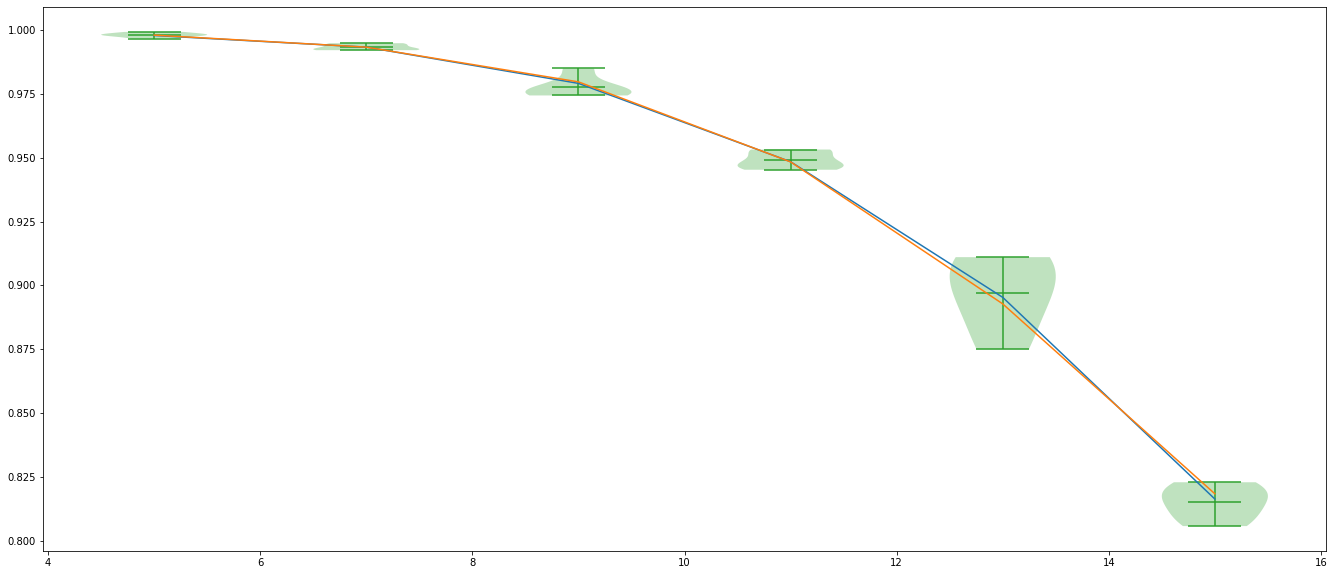

In [22]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=0,
    target=target,
    max_threshold=max_threshold,
    accuracy=accuracy,
)

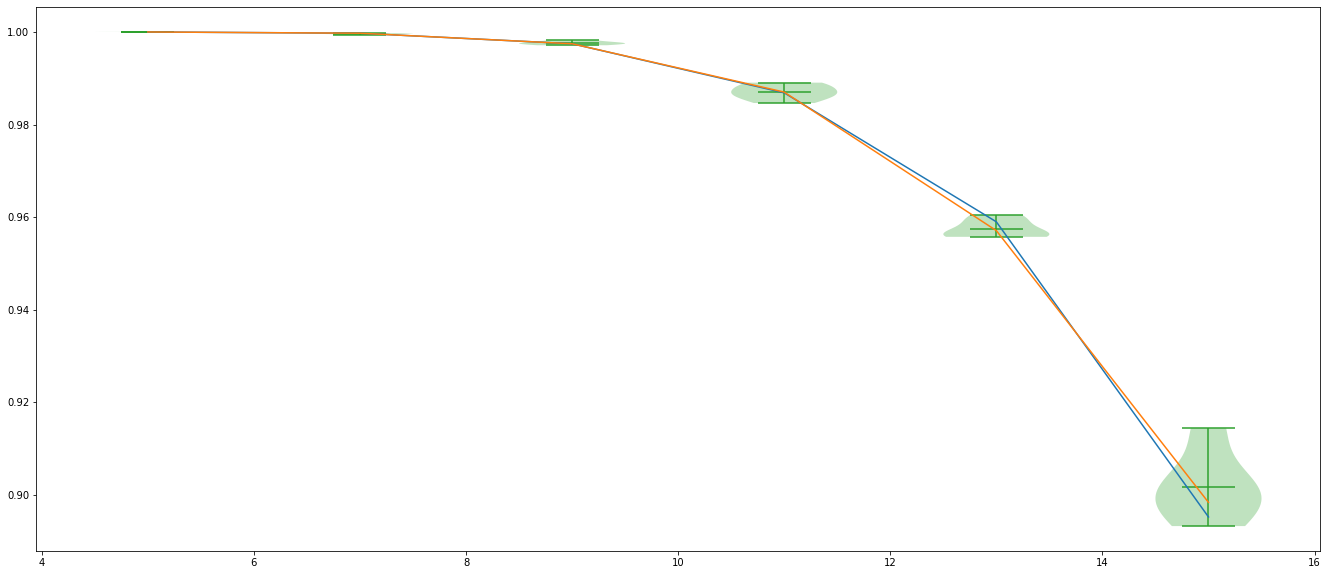

In [23]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=1,
    target=target,
    max_threshold=max_threshold,
    accuracy=accuracy,
)

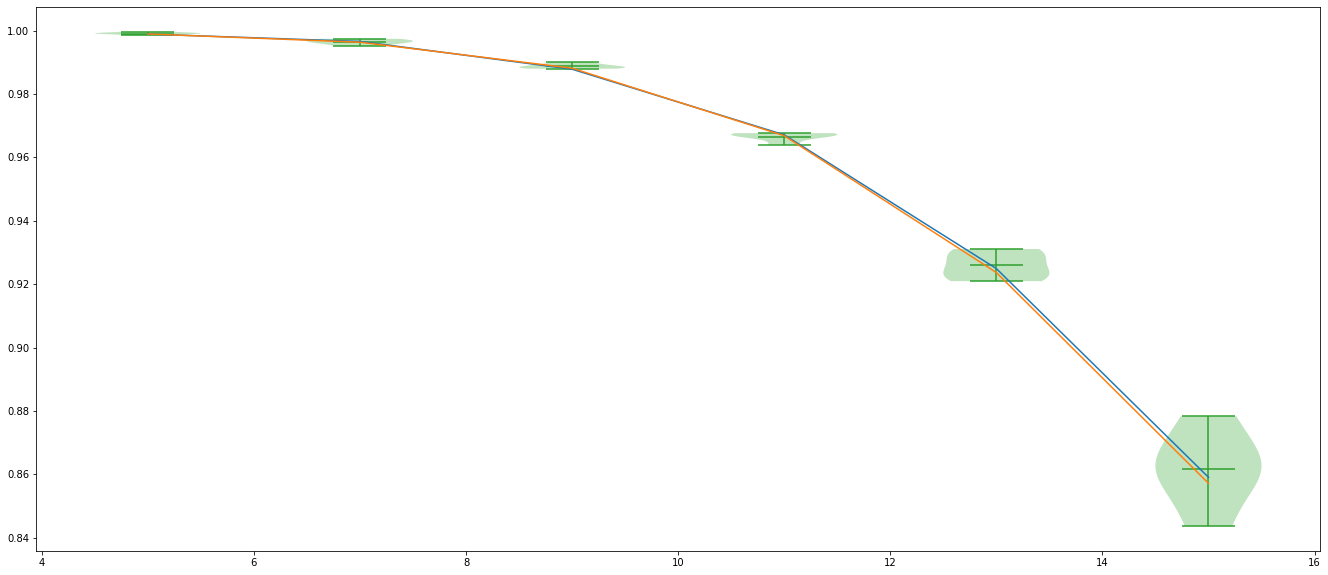

In [15]:
plot_of_proportion_within_target(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    seed_num=seed_num,
    num_of_trials=num_of_trials,
    runtime=runtime,
    class_type=None,
    target=target,
    max_threshold=max_threshold,
    accuracy=accuracy,
)